# Strategic Financial Insight: Complete Analysis Report

## Idaho Policy Institute (IPI) - Municipal Finance & Crime Study

**Project Goal:** Identify relationships between municipal financial decisions and crime rates to inform evidence-based resource allocation strategies.

---

### 📋 Executive Summary

This notebook documents the complete analytical workflow used to identify the correlation between municipal debt and crime rates in Idaho cities. Through rigorous data preprocessing, feature engineering, and statistical modeling, we discovered that **long-term outstanding debt** is the most statistically significant predictor of crime rates.

### 🎯 Key Findings

1. **Primary Discovery:** Long-term debt shows the strongest correlation with crime rates (p < 0.001)
2. **Controlled Analysis:** Effect holds even when controlling for population, general expenditure, and employment
3. **Actionable Insight:** Municipal debt management should be considered in crime prevention strategies

---

**⚠️ Note:** This is an analysis notebook, not intended for live compilation. Some models may produce different results if re-run due to data updates or random seeds.

## Project Background

### Context

This analysis was conducted as a service-learning project for the **Idaho Policy Institute** at Boise State University. The client sought to optimize government resource allocation for crime reduction by understanding how municipal financial decisions correlate with crime rates.

### The Challenge

The Idaho Policy Institute provided a comprehensive dataset containing:
- **Financial data:** Revenue, expenditure, debt, and assets for Idaho municipalities (1995-2014)
- **Crime statistics:** FBI Uniform Crime Reporting data
- **Employment data:** BLS county-level employment statistics
- **Demographic data:** Population and geographic information

### Research Objective

**Primary Question:** How do municipal financial decisions (expenditure priorities, revenue sources, debt levels) correlate with crime rates across Idaho cities of different sizes?

### Analytical Approach

1. **Data Integration:** Merged multiple authoritative data sources
2. **Feature Engineering:** Created normalized, comparable metrics across cities
3. **Temporal Analysis:** Accounted for trends over 20-year period
4. **Statistical Modeling:** OLS time-fixed effects regression with robust controls
5. **Model Validation:** Ensured statistical significance and interpretability

---

## Team & Acknowledgments

### Project Team

| Role | Name | Contribution |
|------|------|--------------|
| **Lead Analyst** | Dominik Huffield | Data engineering, statistical modeling, reporting |
| **Contributor** | Sammy Bhushan | Data exploration, feature engineering |
| **Contributor** | Amir Abbas Kazemzadeh Farizhandi | Data validation, visualization |

### Client & Stakeholders

- **Client:** Idaho Policy Institute, Boise State University
- **Academic Advisor:** Graduate Data Science Program, Boise State University
- **Beneficiaries:** Idaho municipal governments, policy makers, residents

### Data Providers

- U.S. Census Bureau (demographic data)
- Bureau of Labor Statistics (employment & CPI data)
- FBI Uniform Crime Reporting (crime statistics)
- Willamette Government Finance Database (municipal financial data)
- GeoNames (geographic coordinates)

---

## 1. Setup & Imports

### Required Libraries

This analysis uses a combination of custom modules and standard data science libraries:

In [ ]:
# ===== Custom IPI Modules =====
import support.load_data as load              # Data loading and merging
import support.supporting_funcs as funcs      # Feature engineering utilities
# import support.plotting_funcs as ipiplot    # Visualization functions (optional)

# ===== Core Data Science Libraries =====
import pandas as pd
import numpy as np

# ===== Visualization =====
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.lines as mlines

# ===== Statistical Modeling =====
from linearmodels.panel import PanelOLS      # Panel data OLS regression (primary model)
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.tools.tools import add_constant
import sympy

# ===== Machine Learning =====
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.feature_selection import SelectKBest, chi2, f_regression
from sklearn.linear_model import LassoCV, BayesianRidge
from sklearn.ensemble import RandomForestRegressor
from sklearn.pipeline import Pipeline

# ===== Evaluation Metrics =====
from sklearn.metrics import accuracy_score, r2_score, mean_squared_log_error

# ===== Display Settings =====
pd.set_option('display.max_columns', 50)
pd.set_option('display.max_rows', 100)
plt.style.use('seaborn-v0_8-darkgrid')

print("✓ All libraries imported successfully!")
print(f"  NumPy version: {np.__version__}")
print(f"  Pandas version: {pd.__version__}")

### Installation Notes

If your environment is missing required packages, install them using:

**Via Conda (recommended):**
```bash
!conda install -c conda-forge linearmodels statsmodels scikit-learn
```

**Via pip:**
```bash
!pip install linearmodels statsmodels scikit-learn pandas numpy matplotlib seaborn
```

**Or use requirements.txt:**
```bash
!pip install -r requirements.txt
```

For detailed installation instructions, refer to the project README.md file.

---

## 2. Data Understanding

### Dataset Overview

The Idaho Policy Institute provided extensive documentation for the dataset, including:

- **Column Descriptions:** `col_only.csv` contains full descriptions for all 600+ variables
- **Data Dictionary:** Abbreviations, units, sources, and temporal coverage
- **Data Quality Notes:** Known issues, missing data patterns, special cases

**Reference:** For detailed variable descriptions, see the `Library_Demo.ipynb` notebook or use:
```python
columns = load.cols()
funcs.search_column('pattern', columns, disp=True)
```

---

### Integrated Data Sources

To enhance the IPI dataset, we integrated data from multiple authoritative sources:

| Source | Data Provided | Variables | Temporal Coverage |
|--------|---------------|-----------|-------------------|
| **U.S. Census Bureau** | Demographics | Population (city/county/state) | 1990-2014 |
| **Willamette GFD** | Municipal Finance | Cash flow, expenditure, revenue, debt | 1995-2014 |
| **FBI UCR** | Crime Statistics | Offenses by type, arrests, clearances | 1995-2014 |
| **Bureau of Labor Statistics** | Economic Indicators | Employment, unemployment, CPI | 1995-2015 |
| **GeoNames** | Geographic Data | Latitude, longitude, ZIP codes | Current |

### Data Integration Process

1. **IPI Base Data:** Financial and crime data for Idaho municipalities
2. **Employment Merge:** BLS county-level data joined on FIPS code and year
3. **Geographic Merge:** GeoNames coordinates joined on city name
4. **Inflation Adjustment:** BLS CPI used to convert all dollars to Oct 2019 real dollars
5. **Feature Engineering:** Created normalized metrics for cross-city comparisons

**Result:** Comprehensive panel dataset with 600+ variables across 200+ cities over 20 years

---

### Custom Analysis Toolkit

To streamline the analysis, we developed a custom Python toolkit (`support/` module) with specialized functions:

**Data Processing Functions:**
- `gen_real_dollars()` - Inflation adjustment using CPI
- `normalize()` - Create per-capita and percentage features
- `categorize_size()` - Classify cities as rural/non-urban/urban

**Exploration Functions:**
- `search_all()` - Find columns by pattern/regex
- `search_column()` - Search full descriptions

**Visualization Functions:**
- `plot_year()` - Temporal trends with optional grouping
- `plot_corr_matrix()` - Correlation heatmaps
- `plot_scatter_matrix()` - Pairwise relationships with annotations

**Documentation:** For detailed function usage, see `Library_Demo.ipynb`

**Note:** Function implementations are located in the `support/` folder for code organization and reusability. They are well-documented with docstrings and examples.

---

## 3. Data Quality & Preprocessing

### The Data Challenge

### Panel Data Structure

The IPI dataset is **panel data** (also called longitudinal data):
- **Cross-sectional dimension:** ~200 Idaho cities/counties
- **Temporal dimension:** 20 years (1995-2014)
- **Structure:** Multiple observations per city over time

### Data Quality Issues Identified

#### 1. **Temporal Imbalance**
❌ **Problem:** Most cities missing data for several years with no consistent pattern

✅ **Solution:** Identified 4 years with complete data (1997, 2002, 2007, 2012) - a clear 5-year collection pattern

#### 2. **Entity-Level Incompleteness**
❌ **Problem:** Many cities had minimal data across all years

✅ **Solution:** Retained 59 "best cities" with most complete records (see `best_cities.csv`)

#### 3. **County vs. City Data**
❌ **Problem:** Insufficient county-level data for reliable analysis

✅ **Solution:** Focused analysis on city-level data; removed incomplete county observations

#### 4. **Nominal Dollar Values**
❌ **Problem:** Financial data in nominal dollars not comparable across years

✅ **Solution:** Adjusted all financial data to October 2019 real dollars using BLS CPI

### Preprocessing Pipeline

```
Raw Data (200 cities × 20 years)
  ↓
Filter to 4 key years (1997, 2002, 2007, 2012)
  ↓
Select 59 cities with complete data
  ↓
Adjust for inflation (to Oct 2019 dollars)
  ↓
Merge employment & geographic data
  ↓
Create normalized features (per-capita, percentages)
  ↓
Ready for Analysis (59 cities × 4 years = 236 observations)
```

### Implementation

All preprocessing is automated in the `load.all_data()` and `load.ipi_abb()` functions. See details below:

---

## Objective for Models

The amount of columns contained within the set describing crime amounted to 7 however there were over 500 variables describing financial revenue or expenditure. Using this knowledge we thought it best to attempt to describe crime using financial information as our independent variables (along with additional information). We chose to do this so that we would not limit the features available for our models along with the ability of this type of model to provide a good description of the relation between government finances and crime. The variables describing crime were quantities of occurances so to use this as our dependent variable we needed to construct a regression model. 
<br>
A future iteration of this project one might create a classifier that describes whether an increase or decrease in a feature will result in an increase or decease in crime. We do not address this effect of each feature directly to our dependent as to avoid feature phishing.
<br><br>
**Selecting A Model** <br>
Since this a panel dataset we wanted to account for the serial correlation resulting from the time series. Additionally we thought a linear model the easiest to interpret and understand the inner workings of the data itself. This lead us to a time effects model for our initial build, however the world is not linear and features will likely contain heteroskedasticity so past comprehension a non-linear approach will likely be a more robust and accurate model.
<br><br>

## Load Dataset 

Using one of our functions within the support folder, we will take the dataset and convert the financial values from nominal to real dollars creating a dataframe. We use the CPI for 2019 but future analysis should adjust to the most recent CPI value to allow for full comprehension of a dollar.  

In [84]:
df = load.all_data(norm=False)

Loading IPI data
Adjusting for Inflation
Getting GPS
Getting Employees
Merge Everything
Categorize City Size


## Understanding Data Structure

In [85]:
df['Year4'].sort_values().unique()

array([1995, 1996, 1997, 1998, 1999, 2000, 2001, 2002, 2003, 2004, 2005,
       2006, 2007, 2008, 2009, 2010, 2011, 2012, 2013, 2014])

As you can see the range of the time series contains values from 1995 to 2014

In [86]:
df['Name'].unique().size

200

Along the major axis there are 200 different cities 

In [87]:
df.set_index(['Name', 'Year4']).loc[('BOISE CITY',np.arange(1995, 2016)), :]

County  YearofData  SurveyYr           ID  IDChanged  \
Name       Year4                                                        
BOISE CITY 1996     Ada        96.0      96.0  132001001.0        0.0   
           1997     Ada        97.0      97.0  132001001.0        0.0   
           1998     Ada        98.0      98.0  132001001.0        0.0   
           1999     Ada        99.0      99.0  132001001.0        0.0   
           2000     Ada         0.0       0.0  132001001.0        0.0   
           2001     Ada         NaN       1.0  132001001.0        0.0   
           2002     Ada         NaN       2.0  132001001.0        0.0   
           2003     Ada         NaN       3.0  132001001.0        0.0   
           2004     Ada         NaN       4.0  132001001.0        0.0   
           2005     Ada         NaN       5.0  132001001.0        0.0   
           2006     Ada         NaN       6.0  132001001.0        0.0   
           2007     Ada         NaN       7.0  132001001.0        NaN   
           2008     Ada         NaN       8.0  132001001.0        NaN   
           2009     Ada         NaN       9.0  132001001.0        NaN   
           2010     Ada         NaN      10.0  132001001.0        NaN   
           2011     Ada         NaN      11.0  132001001.0        NaN   
           2012     Ada         NaN      12.0  132001001.0        NaN   
           2013     Ada         NaN      13.0  132001001.0        NaN   
           2014     Ada         NaN      14.0  132001001.0        NaN   

                  Type_Code County  FIPS_Code_State  FIPS_County  FIPS_Place  \
Name       Year4                                                               
BOISE CITY 1996         2.0    Ada             16.0          1.0      8830.0   
           1997         2.0    Ada             16.0          1.0      8830.0   
           1998         2.0    Ada             16.0          1.0      8830.0   
           1999         2.0    Ada             16.0          1.0      8830.0   
           2000         2.0    Ada             16.0          1.0      8830.0   
           2001         2.0    Ada             16.0          1.0      8830.0   
           2002         2.0    Ada             16.0          1.0      8830.0   
           2003         2.0    Ada             16.0          1.0      8830.0   
           2004         2.0    Ada             16.0          1.0      8830.0   
           2005         2.0    Ada             16.0          1.0      8830.0   
           2006         2.0    Ada             16.0          1.0      8830.0   
           2007         2.0    Ada             16.0          1.0      8830.0   
           2008         2.0    Ada             16.0          1.0      8830.0   
           2009         2.0    Ada             16.0          1.0      8830.0   
           2010         2.0    Ada             16.0          1.0      8830.0   
           2011         2.0    Ada             16.0          1.0      8830.0   
           2012         2.0    Ada             16.0          1.0      8830.0   
           2013         2.0    Ada             16.0          1.0      8830.0   
           2014         2.0    Ada             16.0          1.0      8830.0   

                  ...      County/State  County FIPS Year  County Labor Force  \
Name       Year4  ...                                                           
BOISE CITY 1996   ...    Ada County, ID            1996.0            150733.0   
           1997   ...    Ada County, ID            1997.0            156552.0   
           1998   ...    Ada County, ID            1998.0            163205.0   
           1999   ...    Ada County, ID            1999.0            166095.0   
           2000   ...    Ada County, ID            2000.0            169932.0   
           2001   ...    Ada County, ID            2001.0            175653.0   
           2002   ...    Ada County, ID            2002.0            175742.0   
           2003   ...    Ada County, ID            2003.0            1770

Here is a visual representation of one of these cities. Notice that for this city there is not data for 1995 and that we have an unbalaced panel. Some cities are missing many more values than this one and we will address this further down.

In [88]:
df.shape

(1509, 631)

Here you can see that we have over 600 variables

In [89]:
df = df.drop(columns= funcs.search_all(df, 'coun'))

County
County
FIPS_County
Counties - Assault- Total
Counties - Burglary- Total
Counties - Manslaughter- Total
Counties - Murder- Total
Counties - Rape-Total
Counties - Robbery- Total
Counties - Total- All Thefts
County FIPS Code
County/State
County FIPS Year
County Labor Force
County Labor Employed
County Labor Unemployed


Again we reference a supporting function which we use to search for and drop all columns representing county level data. During our exploratory analysis we concluded that there was not enough county level data to be beneficial, cities become our major axis

In [90]:
df.shape

(1509, 615)

After refining the granularity of available variables to only consist of city level data we are left with 615 potential features   

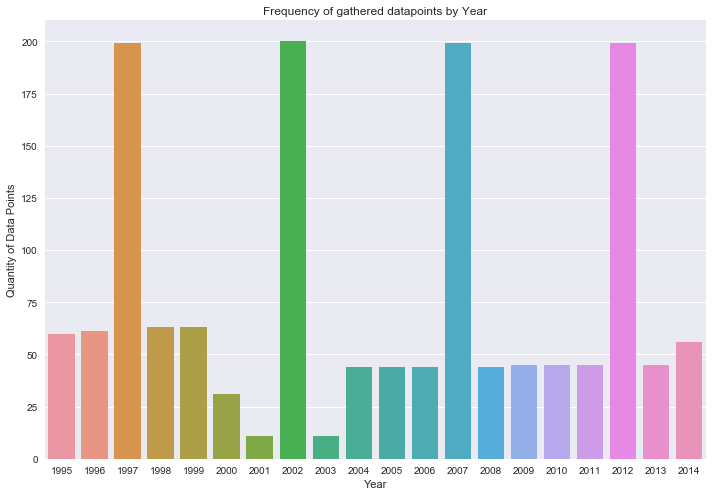

In [91]:
plt.style.use('seaborn')
sns.barplot(x='Year4', y='Population', data=df.groupby('Year4').count().reset_index())
fig = plt.gcf()
fig.set_size_inches(10,7)
plt.ylabel('Quantity of Data Points')
plt.xlabel('Year')
plt.title('Frequency of gathered datapoints by Year')
plt.tight_layout()

In [92]:
df = df.loc[df['Year4'].isin([1997, 2002, 2007, 2012])]

This plot only shows data points for population but during our analysis we identified that this trend was consistent for most variables. Being an unbalanced panel we removed every year other than 1997, 2002, 2007 and 2012. This provides us measurements on the max number of features while also maintaining balance. Removing these years was necessisary to maintain high quality input data. Notice these years are all evenly spaced so change in variables between years will be clear.

## Selecting a Dependant Variable 

As stated under the _"Objective of Model"_ section above; the set contains many statistics desribing the financial activity of each city but only seven variables describing crime. These crime statsistics are unique measuements relative to the financial majority. There are a few other columns not describing finances, such as population, but we concluded that these columns would not provide the same value in identifying relations describing criminal activities and goverment financials. <br><br>

Distinct from crime we also had information on unemployment data and would have liked to use it as the dependent in its own model . We were unable to address this within the time constraint but doing so would likely prove insightful. 

In [93]:
df.shape

(797, 615)

After dropping those years from the set we are left with about 800 rows

In [94]:
cities = (df.groupby('Name')['Assault- Total - Municipalities'].count() == 4)
cities = cities[cities == True].index
df = df[df['Name'].isin(cities)]
df.shape

(236, 615)

Having already removed useless data on our minor axis (years) we then sought to do the same to our major axis (cities). Above we removed any city that did not have data for all four years, this reduced the total records in our dataframe to 236. This unfortunately removed a large portion of the original set but greatly improved the overall quality of our scope.  

In [95]:
tmp = df.notna().sum()
tmp = tmp[tmp > 206]
df = df.loc[:,tmp.index]
df.shape

(236, 101)

Reducing our set an additional time we removed any feature that did not contain values for at least 87% of the total records. This is the penultimate step in our data purification but will will leave us with 236 records or 59 cities each containing data for 4 years and roughly 100 features. 

In [96]:
df = df.set_index(['Name', 'Year4'])

We are now done addressing missing data so we set the indices of our dataframe so that it will be recognized as a panel in future manipulations. 

In [97]:
df.drop(columns=['LAUS Code', 'latitude', 'longitude'],inplace=True)

The column LAUS Code is an object data type and contained little varience so we remnoved it from our set so that we didnt not have to waste time attempting to represent it as quantitative value. Additionally longitude contained negative values that could not be handled in futer models so we chose to remove it along with latitude.

In [98]:
dummies = pd.get_dummies(df['size'])
df.drop(columns=['size'],inplace=True)
df = pd.concat([df, dummies], axis=1)

Size is a catagorical variable and depicts the size of a city so we replaced it with three dummy variables representing its three catagories. 

## Initial Modeling

Our analyses only addresses Total Thefts as our dependent but with minimal reworking one could construct a loop iterating through each crime statistic as the model's dependent variable. 

In [99]:
dep_var = 'Total- All Thefts - Municipalities'
y = df[dep_var]
y = y.rename(dep_var)
y = pd.DataFrame(y)
y = y.astype(int)

Here we save Total Thefts as the dependent variable

In [100]:
X = df.drop(columns = ['Robbery- Total - Municipalities',
       'Rape-Total - Municipalities',
       'Murder- Total - Municipalities', 
       'Total- All Thefts - Municipalities',
       'Manslaughter-Total - Municipalities',
       'Burglary-Total - Municipalities',
       'Assault- Total - Municipalities'])

Now dropping every other crime variable from our data frame as to prevent them from causing undesired noise in our model.

## Interpolation

In [101]:
X = X.interpolate(method='linear')

Finally we believe we have derived the optimal set to attempt to describe theft. However there are still a few null values, so we leverage the panel structure and use interpolate to fill in these nulls. Calculating our own values for these nulls is potentially harmful but we minimzed damage done here because we already dropped features that did not contain values for at least 87% of total records. Additionally notice we do not interpolate on the dependent for we do not want to predict predicted values, regardless "y" contained no missing values and we were able to keep the remaining records. 

## Split

In [102]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

We perform a 20 percent test split but after preprocessing our dataset is much smaller, this is not desired but is prefered over noisy input data.

## Lasso

We need to perform feature selection. We want our features to be independent of one another and we want to use SelectKBest to perform a Chi Squared Test however K is a required parameter to do this. We will use a Lasso Regression to identify how many variables we whould use for SelectKBest. This is our initial model so it will be a little bit of a hack job but further down we will construct a pipeline to optimize K and some other hyperparameters.

In [103]:
reg = LassoCV(cv=3, tol=0.009, random_state=201)
reg.fit(train_X, train_y[dep_var])
print("Best alpha using built-in LassoCV: %f" % reg.alpha_)
print("Best score using built-in LassoCV: %f" %reg.score(train_X,train_y))

Best alpha using built-in LassoCV: 1077134.221116
Best score using built-in LassoCV: 0.902847


In [104]:
coef = pd.Series(reg.coef_, index = train_X.columns)
k_esi = sum(coef != 0)
print("Lasso picked " + str(k_esi) + " variables")

Lasso picked 7 variables


We will use this value for K in SelectKBest

## SelectKBest

In [105]:
selector = SelectKBest(score_func=chi2, k=k_esi)
selector.fit(train_X, train_y)

SelectKBest(k=7, score_func=<function chi2 at 0x1a14cf26a8>)

In [106]:
cols = selector.get_support(indices=True)

X_chi = train_X.iloc[:,cols]
val_X = val_X.iloc[:,cols]

We need the features of our model to only contain features that are independent of one another so to achieve this we use SelectKBest to perform a Chi Squared test and then select K values where K is determined by the previous Lasso regression.

## Handling Multicollinearity

In [107]:
reduced_form, inds = sympy.Matrix(X_chi.values).rref()
X_chi = X_chi.iloc[:, list(inds)]

Handling linear dependence 

In [108]:
# For each X, calculate VIF and save in dataframe
vif = pd.DataFrame()
vif["VIF Factor"] = [variance_inflation_factor(X_chi.values, i) for i in range(X_chi.shape[1])]
vif["features"] = X_chi.columns

Leveraging python's _"Variance Inflation Factor"_ module to systematically remove collinear variables 

In [109]:
indep_var = vif.iloc[vif['VIF Factor'].drop_duplicates().index]['features']
X_chi = X_chi.loc[:,indep_var]
val_X = val_X.loc[:,indep_var]
train_X = X_chi

Transforming our train and test dataframes to only contain desired features.

## Time Effects Regression (OLS)

Having cleaned our data we believe OLS to be BLUE so we can now perform our regression

In [110]:
paneols = PanelOLS(train_y[dep_var],X_chi[indep_var], time_effects=True)
res = paneols.fit()
res

Dep. Variable:,Total- All Thefts - Municipalities,R-squared:,0.9019
Estimator:,PanelOLS,R-squared (Between):,0.9450
No. Observations:,188,R-squared (Within):,-0.3319
Date:,"Fri, Jul 10 2020",R-squared (Overall):,0.9047
Time:,22:54:55,Log-likelihood,-1417.7
Cov. Estimator:,Unadjusted,,
,,F-statistic:,232.42
Entities:,59,P-value,0.0000
Avg Obs:,3.1864,Distribution:,"F(7,177)"
Min Obs:,1.0000,,
Max Obs:,4.0000,F-statistic (robust):,232.42


This model appears to be a good representation of the data. From this we can see that Population, Total_Cash__Securities, Nonin_Trust_Cash__Sec, Total_Expenditure, ect. all are largly statistically significant in identifying Total Theft 
<br><br>
Population and Total Expenditure seem to be accurate in describing Total Theft with low standard errors. This makes logical sense in that the more people in an area the more crime. Oth_Nonin_Fd_Cash__Sec, Tot_Chgs_and_Misc_Rev and Nonin_Trust_Cash___Sec also have low std. errors. 
<br><br>
Our final P-value appears to be statistically significant so lets use our test data to see how it performs with unseen data.

In [111]:
pred_y_pane = res.predict(val_X)
r2_score(val_y, pred_y_pane)

0.8332998470474992

The R squared using unseen data. 
<br>
Our R square dropped a bit but it still appears to be decent. We will make some improvements further down.

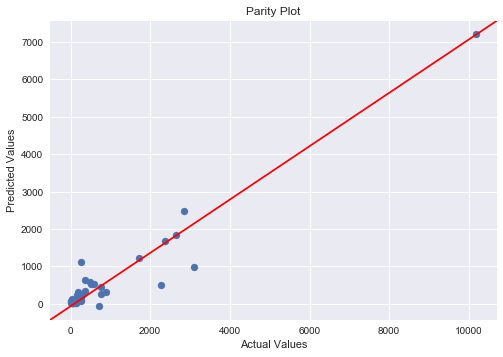

In [112]:
fig, ax = plt.subplots()

ax.scatter(x=val_y, y=pred_y_pane['predictions'])
line = mlines.Line2D([0,1], [0,1], color='red')
transform = ax.transAxes
line.set_transform(transform)
ax.add_line(line)
ax.set_title('Parity Plot')
ax.set_xlabel('Actual Values')
ax.set_ylabel('Predicted Values')
plt.show()

Above is a parity plot simply to give a visual representation of how our model is predicting. From it you can see that the model is optimistically biased and predicting high.  

## Scatter Plots of Dependent against Independent variables

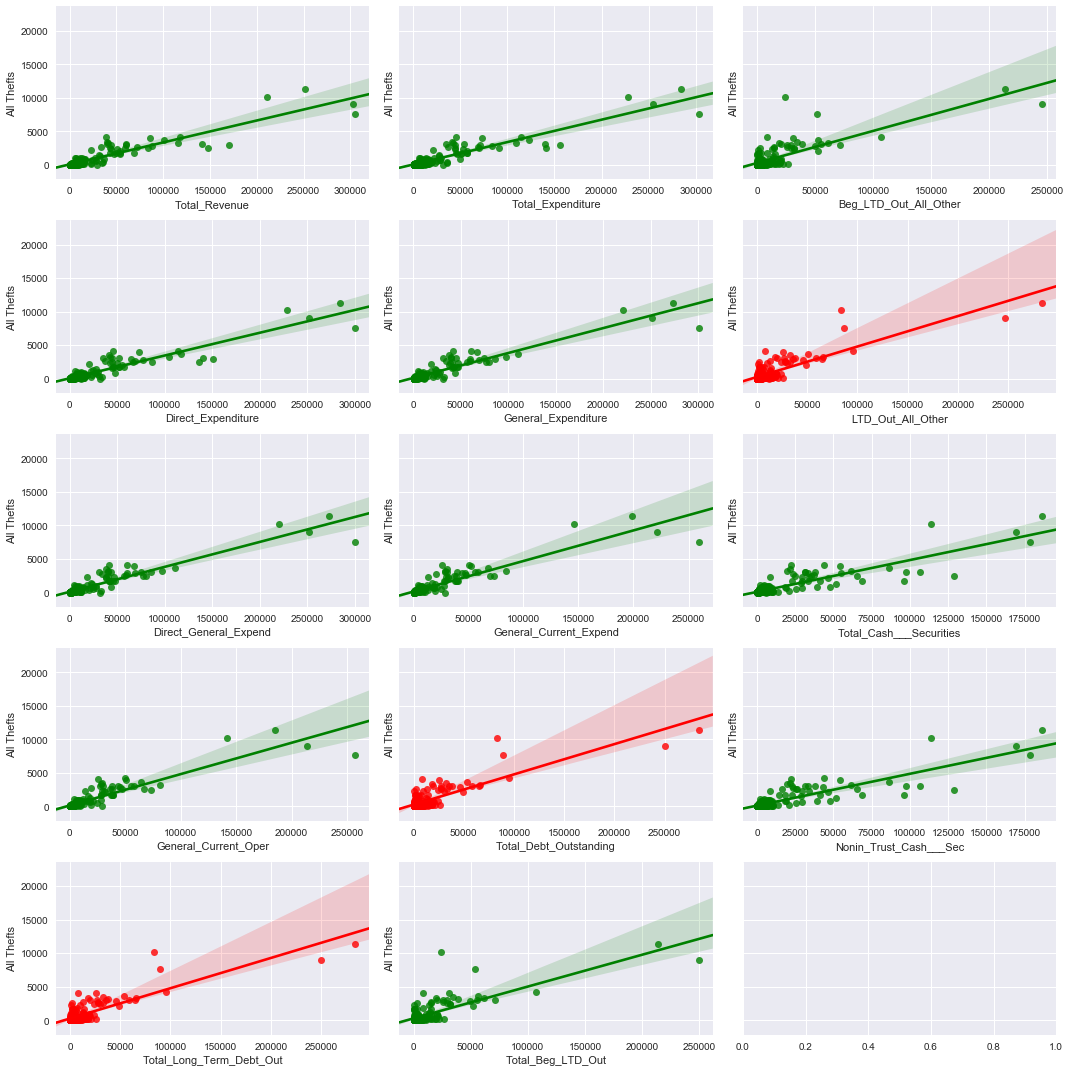

In [113]:
fig1, axs= plt.subplots(figsize=(15,15),nrows=5, ncols=3, sharey=True)
    

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Total_Revenue'], ax=axs[0,0], color='g')
axs[0, 0].set_xlabel("Total_Revenue")
axs[0, 0].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Total_Expenditure'], ax=axs[0,1], color='g')
axs[0, 1].set_xlabel("Total_Expenditure")
axs[0, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Beg_LTD_Out_All_Other'], ax=axs[0,2], color='g')
axs[0, 2].set_xlabel("Beg_LTD_Out_All_Other")
axs[0, 2].set_ylabel('All Thefts')

###############

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Direct_Expenditure'], ax=axs[1,0], color='g')
axs[1, 0].set_xlabel("Direct_Expenditure")
axs[1, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['General_Expenditure'], ax=axs[1,1], color='g')
axs[1, 1].set_xlabel("General_Expenditure")
axs[1, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['LTD_Out_All_Other'], ax=axs[1,2], color='r')
axs[1, 2].set_xlabel("LTD_Out_All_Other")
axs[1, 2].set_ylabel('All Thefts')
##################

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Direct_General_Expend'], ax=axs[2,0], color='g')
axs[2, 0].set_xlabel("Direct_General_Expend")
axs[2, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['General_Current_Expend'], ax=axs[2,1], color='g')
axs[2, 1].set_xlabel("General_Current_Expend")
axs[2, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Total_Cash___Securities'], ax=axs[2,2], color='g')
axs[2, 2].set_xlabel("Total_Cash___Securities")
axs[2, 2].set_ylabel('All Thefts')
###############

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['General_Current_Oper'], ax=axs[3,0], color='g')
axs[3, 0].set_xlabel("General_Current_Oper")
axs[3, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Total_Debt_Outstanding'], ax=axs[3,1], color='r')
axs[3, 1].set_xlabel("Total_Debt_Outstanding")
axs[3, 1].set_ylabel('All Thefts')


sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Nonin_Trust_Cash___Sec'], ax=axs[3,2], color='g')
axs[3, 2].set_xlabel("Nonin_Trust_Cash___Sec")
axs[3, 2].set_ylabel('All Thefts')
##################

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Total_Long_Term_Debt_Out'], ax=axs[4,0], color='r')
axs[4, 0].set_xlabel("Total_Long_Term_Debt_Out")
axs[4, 0].set_ylabel('All Thefts')

sns.regplot(y=y['Total- All Thefts - Municipalities'], x=X['Total_Beg_LTD_Out'], ax=axs[4,1], color='g')
axs[4, 1].set_xlabel("Total_Beg_LTD_Out")
axs[4, 1].set_ylabel('All Thefts')



plt.tight_layout()

Taking a few of the independent varibles and ploting them against the dependent there arises some heteroskedasticity, as shown above, so a non-linear estimator will likely produce the best model. One might perform an F-test for validation but lets run with this.

## Bayesian Ridge Regression

In [114]:
clf = BayesianRidge(compute_score=True)
clf.fit(train_X, train_y)
pred_y_baye = clf.predict(val_X)

/Users/dom/anaconda3/lib/python3.7/site-packages/sklearn/utils/validation.py:761: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [115]:
r2_score(val_y, pred_y_baye)

0.8631852866124068

The R squared using unseen data
<br>
Compared to our time effects model this provided a pretty decent prediction

## Random Forest

In [116]:
regr = RandomForestRegressor(n_estimators=100, random_state=201)
regr.fit(train_X, train_y)
pred_y_rand = regr.predict(val_X)

/Users/dom/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


In [117]:
r2_score(val_y, pred_y_rand)

0.9310881679861482

The R squared using unseen data
<br>
Slightly lower than the ridge model but being a random model we should attempt to optimize the parameter n_estimators.

In [118]:
np.sqrt(mean_squared_log_error(val_y, pred_y_rand))

1.230177740407641

The RSME using unseen data

## Optimizing HyperParameters with GridSearchCV

In [119]:
train_X, val_X, train_y, val_y = train_test_split(X, y, test_size=0.2)

We will redo the split because we altered the training data during the Chi Squared test earlier  

In [120]:
tuned_params = [{'kbest__k':np.arange(5,X.columns.size//2, 5), 'rand__n_estimators':[5,10,50,100,500,1000]}]
model = SelectKBest(score_func=chi2, k=2)

pipeline = Pipeline([('kbest',model), ('rand', RandomForestRegressor(n_estimators=5, random_state=201))])

clf = GridSearchCV(estimator=pipeline, param_grid=tuned_params, cv=5, refit=True, scoring='neg_mean_squared_error')

clf.fit(train_X, train_y[dep_var])

/Users/dom/anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_search.py:841: DeprecationWarning: The default of the `iid` parameter will change from True to False in version 0.22 and will be removed in 0.24. This will change numeric results when test-set sizes are unequal.
  DeprecationWarning)


GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Pipeline(memory=None,
     steps=[('kbest', SelectKBest(k=2, score_func=<function chi2 at 0x1a14cf26a8>)), ('rand', RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity...mators=5, n_jobs=None,
           oob_score=False, random_state=201, verbose=0, warm_start=False))]),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid=[{'kbest__k': array([ 5, 10, 15, 20, 25, 30, 35, 40]), 'rand__n_estimators': [5, 10, 50, 100, 500, 1000]}],
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

Using a pipeline with SelectKBest, RandomForest and GridSearchCV we optimized K of SelectKBest and the number of estimators (n) of RandomForest. We used GridSearchCV which is rather exhaustive but could likely become more efficient if replaced by RandomSearch 

In [121]:
clf.best_params_

{'kbest__k': 35, 'rand__n_estimators': 5}

The optimal values according to our pipeline 

In [122]:
pred_y_grid = clf.predict(val_X)
r2_score(val_y, pred_y_grid)

0.8375486072443916

The R squared using unseen data
<br>
This provided us with the best model, furthermore this pipeline could easily be isolated with the preprocessing steps and turned into a pickle for further use.

In [123]:
np.sqrt(mean_squared_log_error(val_y, pred_y_grid))

0.6822454745533553

The RSME using unseen data
<br>
Our RSME got slightly worse so this model could become more robust.

## Potential Future Steps

From this analysis we have provided a linear model estimating total theft of Idaho cities. Furthermore we constructed a pipeline that produces a more robust model. For further iterations of the project there are serveral places of potential improvement. <br>
>- Feature engineering & importing relevent data. <br>
* Perform a better imputation technique. <br>
- Perform further test to determine optimal features. <br>
- Replace GridSearch with RandomSearch or some other better method to optimize hyper parameters. <br>
- Improve models by using a more effective algorithm or better yet applying deep learning techniques. <br>
- Package everything into a pickle   <br>
- Construct models for the other variables measuring crime <br>